In [1]:
import ginsim
import biolqm

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

This notebook has been executed using the docker image `colomoto/colomoto-docker:2022-07-01`

# MACROPHAGE POLARIZATION LOGICAL MODELLING

This notebook represents a workflow of analyzing a Macrophage Polarization (MacPol) model that was extended from the efforts of Viviam Solangeli Bermúdez Paiva and Marco Fariñas.

#### Section about what macrophages are

#### Section about the model in general

#### The aim of the notebook
The main aim of the notebook is to compute stable states of the model with different growth factor stimuli. Stable states were identified for both M1 and M2 macrophages using LPS + IFNg and IL-4 + IL-13, respectively. To achieve this, bioLQM was used.


## Loading and visualizing the network

In [2]:
MacPol = ginsim.load("MacPol Extended model.zginml")
# ginsim.show(gs_model) --> This command does not show all colors from the original GINsim Model, therefore an image is shown instead.

<img src="http://127.0.0.1:8888/view/notebooks/Master-thesis/MacPol-Extended.jpeg" style="height:300px" />


**Figure 1: Extended Macrophage Polarization (MacPol) model.**
<br>Nodes represent proteins, transcription factors, genes, or ions. Relationships between nodes are represented as edges, where green arrows represent activation, and red blunted arrows represent inhibition of the target node. Orange nodes: external stimuli and receptors. Turqoise nodes: Novel nodes of the extended model. Red nodes: entities related to the M1 phenotype. Blue nodes: entities related to the M2 phenotype. Purple nodes: entities related to both phenotypes. Yellow nodes: entities related to the lipid metabolism mediated by Cytosolic enzyme phospholipase A2 (cPLA2).
Furthermore, the middle nodes in general represent intracellular signaling molecules and transcription factors, while the bottom nodes are molecules secreted or expressed (cytokines, chemokines, and membrane markers).

Converting the model to biolqm and pint compliant models:

In [3]:
lqm_model = ginsim.to_biolqm(MacPol)
pint_model = biolqm.to_pint(lqm_model)

Obtaining a summary of the general model properties:

In [4]:
pint_model.summary()

{'nb_automata': 84,
 'nb_local_states': 168,
 'max_local_states': 2,
 'nb_transitions': 258,
 'nb_states': 19342813113834066795298816}

nb_automata signifies the number of nodes,
nb_local_states is the sum of the number of local states in each automaton,
max_local_states gives the number of local states of the largest automaton,
nb_transitions is the number of defined local transitions,
and nb_states is the total number of global states (corresponds to 2<sup>84</sup> in this case).

## Node - Phenotype associations

Represented below are the nodes with the corresponding phenotype listed. In total, the model contains 18 nodes associated with the M1 phenotype, 22 nodes associated with the M2 phenotype and 11 nodes associated with both phenotypes. In addition, 4 nodes are associated with the lipid metabolism, here noted as "LM".

In [5]:
Node_phenotype = {"Node": ['IRF3','TBK1','STAT5','IRF5','STAT1','IFNa','IFNb','TNFa','RelA','NFkB','IL1b','IL1a','CCL2','iNOS','CCL4','CD80','IL12','CCR7','TRAF6','JNK','p38','SOCS3','MNK1','AP1','IL6','IL1Ra', 'IL8','SNAIL', 'PI3K', 'ERK','PPARG','STAT6','JMJD3','STAT3','SOCS1','IRF4','KLF4','Arg1','CCL17','CCL18','CCL22','cMaf','IL10','CD206','CD200R','CD163','TGFb', 'PDL1', 'HGF', 'IGF1', 'VEGF', 'Ca2', 'cPLA2a', 'PGE2', 'COX2'], 
                 "Phenotype": ['M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2', 'M1 & M2', 'M1 & M2','M1 & M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2','M2', 'LM', 'LM', 'LM', 'LM']}

print("Table 1. Relationship between the specific macrophage secretions and their associated phenotype. LM = Lipid metabolism.")
df_phen = pd.DataFrame(data=Node_phenotype)
df_phen.style.hide(axis='index')

Table 1. Relationship between the specific macrophage secretions and their associated phenotype. LM = Lipid metabolism.


Node,Phenotype
IRF3,M1
TBK1,M1
STAT5,M1
IRF5,M1
STAT1,M1
IFNa,M1
IFNb,M1
TNFa,M1
RelA,M1
NFkB,M1


## Identification of stable states using bioLQM

The original MacPol model developed by Viviam Bérmudez Paiva, has here been extended to include intracellular and extracellular effects of growth factors. This is due to the wish of identifying the stable states for when growth factors are present in the extracellular environment, along with stimuli for polarizing the macrophages into a phenotype, identical to what was performed in the THP-1 experiments.

In [6]:
# Computing all stable states
fixpoints = biolqm.fixpoints(lqm_model)
print("Table 2. All possible stable states.")
fix_df = pd.DataFrame(fixpoints)
fix_df

Table 2. All possible stable states.


,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,PlGF,VEGFR,PDL1,VEGF,IL8,IGF1,IGF1_e,IGF1R,HGF
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33695,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,0
33696,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
33697,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0
33698,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0


When computing the stable states using bioLQM, as shown above in Table 1, a total of 33700 stable states is obtained. This is without defining any initial input states. As shown in the model, there are a total of XX inputs (ligands), and thus it is expected to obtain a total of 2<sup>XX</sup> = XX stable states. An excess amount of stable states signifies the presence of multistability for some input conditions, i.e. the system is able to achieve multiple stable states under the same external conditions.

### COMPARISON OF METHODS FOR CREATING INITIAL CONDITIONS AND OBTAINING STABLE STATES

When comparing this notebook to that of Viviam, it was identified that we used different methods for defining stable states. This difference had to be investigated to check if the resulting dataframes are identical or not. 

In [7]:
# Viviam's method:
condition = biolqm.perturbation(lqm_model, "IFNg%1 LPS%1 VEGF_e%0 PlGF%0 GMCSF%0 IL6_e%0 IL1b_e%0 IC%0 PGE2_e%0 IL4%0 IL13%0 IL10_e%0 HGF_e%0 TGFb_e%0 IGF1_e%0")
fps_condition = biolqm.fixpoints(condition, "-u asynchronous")
condition_df = pd.DataFrame(fps_condition)
condition_df

,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,PlGF,VEGFR,PDL1,VEGF,IL8,IGF1,IGF1_e,IGF1R,HGF
0,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [8]:
# My chosen method:
inpM1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
filtered_fixpoints = fix_df.query(inpM1)
filtered_fixpoints


,IFNg,IFNgR,P2R,GMCSF,CSF2RA,IL6_e,IL6R,IL1b_e,IL1R,LPS,TLR4,IC,FCGR,IL4,IL4RA,IL13,IL10_e,IL10R,PGE2_e,EP4R,STAT5,STAT1,IRF5,IRF3,IFNb,NFkB,RelA,IL1a,IFNa,iNOS,IL1b,TNFa,IL12,CCL4,CCL2,CD80,CCR7,TBK1,TRAF6,JNK,p38,MNK1,SOCS3,AP1,IL6,IL1Ra,ERK,PPARG,JMJD3,STAT6,SOCS1,KLF4,IRF4,cMaf,Arg1,CD200R,CCL18,CCL17,CCL22,CD206,IL10,STAT3,TGFb,CD163,cPLA2a,PGE2,COX2,Ca2,HGF_e,cMET,PI3K,TGFb_e,TGFR,SNAIL,VEGF_e,PlGF,VEGFR,PDL1,VEGF,IL8,IGF1,IGF1_e,IGF1R,HGF
17985,1,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


As can be seen, the two methods yield the same results, except the row labels differ.The row label from my method is coming from the index in fix_df, whereas for Viviam's method, the number will be either 0 or 1 due to creating one data frame per condition. Hence, the conclusion is that I can continue with my method of choice. 

### Creating initial conditions and computing the corresponding stable states

To compute the reachable stable states with different stimuli, initial state conditions must first be defined. M0 has been included, in addition to M1 and M2 because it establishes a baseline which can be used for comparison.Additionally, it offers a more nuanced and complete picture of how growth factors influence macrophage polarization across the spectrum of phenotypes.

In [9]:
# Creating initial state conditions:
inpM0 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_HGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM0_VEGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 1 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_PlGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM0_TGFb = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM0_IGF1 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')

inpM1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_HGF = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM1_VEGF = ('IFNg == 1 & LPS == 1 & VEGF_e == 1 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_PlGF = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM1_TGFb = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM1_IGF1 = ('IFNg == 1 & LPS == 1 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 0 & IL13 == 0 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')

inpM2 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_HGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 1 & TGFb_e == 0 & IGF1_e == 0')
inpM2_VEGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 1 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_PlGF = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 1 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 0')
inpM2_TGFb = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 1 & IGF1_e == 0')
inpM2_IGF1 = ('IFNg == 0 & LPS == 0 & VEGF_e == 0 & PlGF == 0 & GMCSF == 0 & IL6_e == 0 & IL1b_e == 0 & IC == 0 & PGE2_e == 0 & IL4 == 1 & IL13 == 1 & IL10_e == 0 & HGF_e == 0 & TGFb_e == 0 & IGF1_e == 1')


# Preparing indexes for all output nodes
markers = ['IRF3','TBK1','STAT5','IRF5','STAT1','IFNa','RelA','NFkB','IFNb','TNFa','IL1b','IL1a','iNOS','CCL2','CCL4','CD80','IL12','CCR7','TRAF6','JNK','SOCS3','p38','MNK1','AP1','IL6','IL1Ra','ERK','PPARG','STAT6','JMJD3','STAT3','SOCS1','IRF4','Arg1','KLF4','CCL18','CCL17','CD200R','CD206','CCL22','CD163','cMaf','IL10','TGFb', 'PDL1', 'IL8', 'HGF', 'IGF1', 'PI3K','SNAIL', 'VEGF' ]

phen_arrays = [['M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2','M1 & M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M2', 'M1 & M2', 'M1 & M2', 'M2', 'M1 & M2', 'M1 & M2', 'M2' ], markers]

Workflow for the following two cells:
1) Setting the initial states. ".query" in the pandas library asks a boolean expression to each of the columns in the Dataframe.

2) Selecting only the output nodes to appear in heat map.

3) Creating a multilevel index with the phenotypes, which makes it possible to store and manipulate data with an arbitrary number of dimensions in lower dimensional data structures like dataframes.

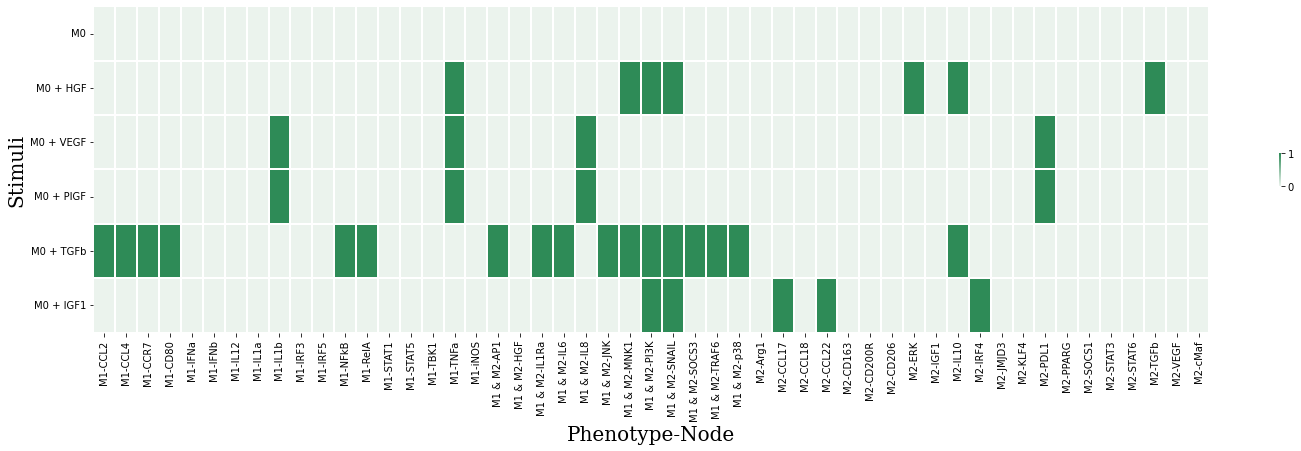

In [10]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 in M0 macrophages
# Selecting only the output nodes.
# Creating a multilevel indexs with the phenotypes.

M0_ON = fix_df.query(inpM0)
M0_ON = M0_ON[markers]
M0_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_HGF = fix_df.query(inpM0_HGF)
M0_HGF = M0_HGF[markers]
M0_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_VEGF = fix_df.query(inpM0_VEGF)
M0_VEGF = M0_VEGF[markers]
M0_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_PlGF = fix_df.query(inpM0_PlGF)
M0_PlGF = M0_PlGF[markers]
M0_PlGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_TGFb = fix_df.query(inpM0_TGFb)
M0_TGFb = M0_TGFb[markers]
M0_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M0_IGF1 = fix_df.query(inpM0_IGF1)
M0_IGF1 = M0_IGF1[markers]
M0_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

frames = [M0_ON, M0_HGF, M0_VEGF, M0_PlGF, M0_TGFb, M0_IGF1]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M0", "M0 + HGF", "M0 + VEGF", "M0 + PlGF", "M0 + TGFb", "M0 + IGF1"])

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

fig, ax = plt.subplots(figsize=(25, 6)) 

# Filter the DataFrame to keep only the columns representing the data for the heatmap
data_for_heatmap = results.drop(['level_0', 'level_1'], axis=1)                 

M0map = sns.heatmap(data_for_heatmap, cmap = sns.light_palette("seagreen", as_cmap=True), square = False, linewidth=0.1, 
                    cbar_kws={"shrink": .1})

# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M0map.set_yticklabels(results['level_0'].values, rotation=0)

M0map.set_ylabel("Stimuli", fontsize=20, font="Serif" )
M0map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")
plt.show()




**Figure 2. Predicted stable states in M0 macrophages**
M0 macrophages along with the stimuli of different growth factor. Green cells are activated nodes, while white nodes are inactivated.

In [11]:
# ANALYSIS
# Creating lists of nodes based on phenotype
M1_nodes = df_phen[df_phen['Phenotype'] == 'M1']['Node'].tolist()
M2_nodes = df_phen[df_phen['Phenotype'] == 'M2']['Node'].tolist()

# Concatenating the lists
M1_M2_nodes = M1_nodes + M2_nodes

# Creating a dictionary
ratios_dict = {}

# Going through each row (stimulus)
for stimulus in results['level_0'].unique(): # ['M0' 'M0 + HGF' 'M0 + VEGF' 'M0 + PlGF' 'M0 + TGFb' 'M0 + IGF1']
    stimulus_df = results[results['level_0'] == stimulus].loc[:, pd.IndexSlice[:, M1_M2_nodes]]
    
    # Filtering
    M1_nodes_filter = pd.IndexSlice['M1', M1_nodes]
    M2_nodes_filter = pd.IndexSlice['M2', M2_nodes]

    # Counting the active M1 and M2 nodes for each row
    m1_count = stimulus_df.loc[:, M1_nodes_filter].apply(lambda x: sum(x == 1), axis=1)
    m2_count = stimulus_df.loc[:, M2_nodes_filter].apply(lambda x: sum(x == 1), axis=1)

    # Initializing ratio as a series of zeros
    ratio = m1_count.astype(str) + '/' + m2_count.astype(str)

    # Storing the ratio in the dictionary
    ratios_dict[stimulus] = ratio

# Converting the dictionary to a Dataframe
ratios_df = pd.DataFrame.from_dict(ratios_dict)

# Melting the DataFrame
df_melted = ratios_df.melt(var_name='Stimuli', value_name='Active M1/M2')

# Dropping NaN rows
df_melted.dropna(inplace=True)

# Changing the row indexes
df_melted.index = ['1', '2', '3', '4', '5','6']

print("""Table 3. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.\n""")
print(df_melted)


Table 3. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.

     Stimuli Active M1/M2
1         M0          0/0
2   M0 + HGF          1/3
3  M0 + VEGF          2/1
4  M0 + PlGF          2/1
5  M0 + TGFb          6/1
6  M0 + IGF1          0/3


Figure 3. Predicted stable states when M1 input ligands IFNg and LPS are on, along with one other growth factor stimuli.


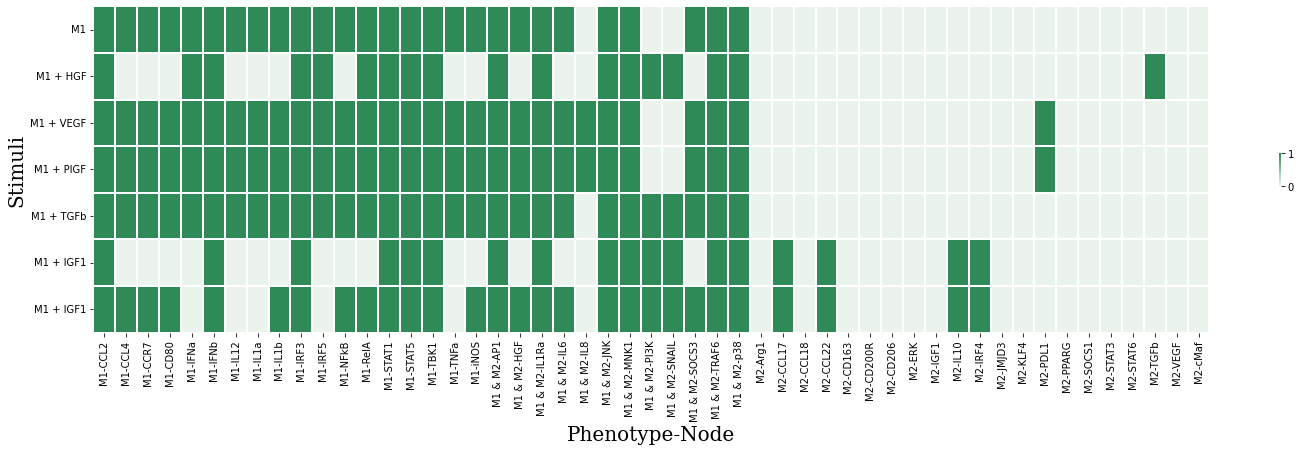

In [12]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 along with M1 phenotype stimuli.
# Selecting only the output nodes.
# Creating a multilevel indexs with the phenotypes.

M1_ON = fix_df.query(inpM1)
M1_ON = M1_ON[markers]
M1_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_HGF = fix_df.query(inpM1_HGF)
M1_HGF = M1_HGF[markers]
M1_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_VEGF = fix_df.query(inpM1_VEGF)
M1_VEGF = M1_VEGF[markers]
M1_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_PlGF = fix_df.query(inpM1_PlGF)
M1_PlGF = M1_PlGF[markers]
M1_PlGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_TGFb = fix_df.query(inpM1_TGFb)
M1_TGFb = M1_TGFb[markers]
M1_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M1_IGF1 = fix_df.query(inpM1_IGF1)
M1_IGF1 = M1_IGF1[markers]
M1_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

frames = [M1_ON, M1_HGF, M1_VEGF, M1_PlGF, M1_TGFb, M1_IGF1]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M1", "M1 + HGF", "M1 + VEGF", "M1 + PlGF", "M1 + TGFb", "M1 + IGF1"])

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

print("Figure 3. Predicted stable states when M1 input ligands IFNg and LPS are on, along with one other growth factor stimuli.")
fig, ax = plt.subplots(figsize=(25, 6)) 

# Filter the DataFrame to keep only the columns representing the data for the heatmap
data_for_heatmap = results.drop(['level_0', 'level_1'], axis=1)                 

M1map = sns.heatmap(data_for_heatmap, cmap = sns.light_palette("seagreen", as_cmap=True), square = False, linewidth=0.1, 
                    cbar_kws={"shrink": .1})

# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M1map.set_yticklabels(results['level_0'].values, rotation=0)

M1map.set_ylabel("Stimuli", fontsize=20, font="Serif" )
M1map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")
plt.show()


**Figure 3. Predicted stable states in M1 macrophages**
M1 macrophages along with the stimuli of different growth factor. Green cells are activated nodes, while white cells are inactivated nodes.

In [13]:
# ANALYSIS
# Creating a dictionary
ratios_dict = {}

# Going through each row (stimulus)
for stimulus in results['level_0'].unique(): # ['M0' 'M0 + HGF' 'M0 + VEGF' 'M0 + PlGF' 'M0 + TGFb' 'M0 + IGF1']
    stimulus_df = results[results['level_0'] == stimulus].loc[:, pd.IndexSlice[:, M1_M2_nodes]]
    
    # Filtering
    M1_nodes_filter = pd.IndexSlice['M1', M1_nodes]
    M2_nodes_filter = pd.IndexSlice['M2', M2_nodes]

    # Counting the active M1 and M2 nodes for each row
    m1_count = stimulus_df.loc[:, M1_nodes_filter].apply(lambda x: sum(x == 1), axis=1)
    m2_count = stimulus_df.loc[:, M2_nodes_filter].apply(lambda x: sum(x == 1), axis=1)

    # Initializing ratio as a series of zeros
    ratio = m1_count.astype(str) + '/' + m2_count.astype(str)

    # Storing the ratio in the dictionary
    ratios_dict[stimulus] = ratio

# Converting the dictionary to a Dataframe
ratios_df = pd.DataFrame.from_dict(ratios_dict)

# Melting the DataFrame
df_melted = ratios_df.melt(var_name='Stimuli', value_name='Ratio')

# Dropping NaN rows
df_melted.dropna(inplace=True)

# Changing the row indexes
df_melted.index = ['1', '2', '3', '4', '5','6','7']

print("""Table 4. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.\n""")
print(df_melted)

Table 4. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.

     Stimuli Ratio
1         M1  18/0
2   M1 + HGF   9/1
3  M1 + VEGF  18/1
4  M1 + PlGF  18/1
5  M1 + TGFb  18/0
6  M1 + IGF1   6/4
7  M1 + IGF1  13/4


As shown in Figure 3, there is one predicted stable state for each condition, except for M1 + IGF-1 stimuli, where two stable states are obtained. Thus, multistability with IGF-1 stimuli in M1 macrophages is obtainable according to the model.

Figure 4. Predicted stable states when M2 input ligands IL-4 and IL-13 are on, along with one other growth factor stimuli. 


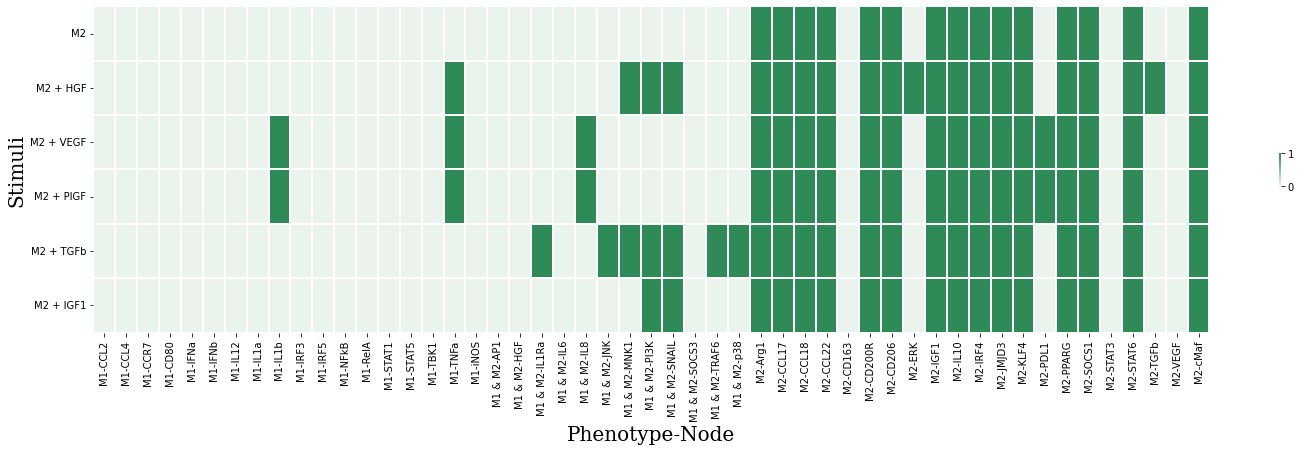

In [14]:
# Setting initial states with growth factors HGF, VEGF, PlGF, TGFb, IGF1 along with M2 phenotype stimuli.
# Selecting only the output nodes.
# Creating a multilevel indexs with the phenotypes.

M2_ON = fix_df.query(inpM2)
M2_ON = M2_ON[markers]
M2_ON.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_HGF = fix_df.query(inpM2_HGF)
M2_HGF = M2_HGF[markers]
M2_HGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_VEGF = fix_df.query(inpM2_VEGF)
M2_VEGF = M2_VEGF[markers]
M2_VEGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_PlGF = fix_df.query(inpM2_PlGF)
M2_PlGF = M2_PlGF[markers]
M2_PlGF.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_TGFb = fix_df.query(inpM2_TGFb)
M2_TGFb = M2_TGFb[markers]
M2_TGFb.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

M2_IGF1 = fix_df.query(inpM2_IGF1)
M2_IGF1 = M2_IGF1[markers]
M2_IGF1.columns = pd.MultiIndex.from_arrays(phen_arrays, names= ['Phenotype', 'Node'])

frames = [M2_ON, M2_HGF, M2_VEGF, M2_PlGF, M2_TGFb, M2_IGF1]

# Concatenating all the filtered dataframes into one large dataframe
results = pd.concat(frames, keys=["M2", "M2 + HGF", "M2 + VEGF", "M2 + PlGF", "M2 + TGFb", "M2 + IGF1"])

# Resetting the index to move the stimuli names to columns
results.reset_index(inplace=True)

# Lexsorting the MultiIndex
results = results.sort_index(axis=1)

print("Figure 4. Predicted stable states when M2 input ligands IL-4 and IL-13 are on, along with one other growth factor stimuli. ")
fig, ax = plt.subplots(figsize=(25, 6))                   
                    
# Filter the DataFrame to keep only the columns representing the data for the heatmap
data_for_heatmap = results.drop(['level_0', 'level_1'], axis=1)  

M2map = sns.heatmap(data_for_heatmap, cmap = sns.light_palette("seagreen", as_cmap=True), square = False, linewidth=0.1, cbar_kws={"shrink": .1})

# Setting y-axis labels using the 'level_0' column which contains the stimuli names
M2map.set_yticklabels(results['level_0'].values, rotation=0)

M2map.set_ylabel("Stimuli", fontsize=20, font="Serif")
M2map.set_xlabel("Phenotype-Node", fontsize=20, font="Serif")
plt.show()


**Figure 3. Predicted stable states in M2 macrophages**
M2 macrophages along with the stimuli of different growth factor. Green cells are activated nodes, while white cells are inactivated nodes.

In [15]:
# ANALYSIS
# Creating a dictionary
ratios_dict = {}

# Going through each row (stimulus)
for stimulus in results['level_0'].unique(): # ['M0' 'M0 + HGF' 'M0 + VEGF' 'M0 + PlGF' 'M0 + TGFb' 'M0 + IGF1']
    stimulus_df = results[results['level_0'] == stimulus].loc[:, pd.IndexSlice[:, M1_M2_nodes]]
    
    # Filtering
    M1_nodes_filter = pd.IndexSlice['M1', M1_nodes]
    M2_nodes_filter = pd.IndexSlice['M2', M2_nodes]

    # Counting the active M1 and M2 nodes for each row
    m1_count = stimulus_df.loc[:, M1_nodes_filter].apply(lambda x: sum(x == 1), axis=1)
    m2_count = stimulus_df.loc[:, M2_nodes_filter].apply(lambda x: sum(x == 1), axis=1)

    # Initializing ratio as a series of zeros
    ratio = m1_count.astype(str) + '/' + m2_count.astype(str)

    # Storing the ratio in the dictionary
    ratios_dict[stimulus] = ratio

# Converting the dictionary to a Dataframe
ratios_df = pd.DataFrame.from_dict(ratios_dict)

# Melting the DataFrame
df_melted = ratios_df.melt(var_name='Stimuli', value_name='Ratio')

# Dropping NaN rows
df_melted.dropna(inplace=True)

# Changing the row indexes
df_melted.index = ['1', '2', '3', '4', '5','6']

print("""Table 3. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.\n""")
print(df_melted)

Table 3. Activated M1/M2 ratio for each stimuli. Ratio > 1 signifies a majority of activated M1 nodes. 
         'inf' signifies zero activated M2 nodes.

     Stimuli Ratio
1         M2  0/15
2   M2 + HGF  1/17
3  M2 + VEGF  2/16
4  M2 + PlGF  2/16
5  M2 + TGFb  0/15
6  M2 + IGF1  0/15


As shown in Figure 4, there is one predicted stable state for each initial condition.